# Ling113 Unit 2 Replication data visualization

The purpose of this notebook is to create visualizations with the data from our replication of Experiment 1 from Connine and Clifton (1987). There are a few differences between our replication and the original that should not affect the interpretability of our outcomes, but is worth noting:
- The voice onset time (VOT) values of the stimuli are 0/20/40/60/80 miliseconds (ms) rather than the 10/15/20/25/30/35/40/45 ms of the original study.
- The original study included the two series _*dype\~type, dice\~*tice_ which are included in our replication, as well as three series with disyllabic words that aren't included, _*DIgress\~TIgress, diGRESS\~*tiGRESS, *breFER\~preFER_, and _BRIEFer~*PREfer_.
- Our replication was conducted online rather than in person in a lab.
- Subjects in the original study were instructed to identify whether the first consonant was 'p/t' vs. 'b/d'. In our replication, the intended words or nonce words were printed on the screen to help participants with their choices.

## Import libraries and data

In [1]:
import urllib  # to download file
import pandas as pd  # for dataframes
import seaborn as sns  # for visualization
import matplotlib.pyplot as plt  # for figure specifications

This notebook assumes that it is located in the same folder as the data, and that the data is named "responses.csv". If the file is located elsewhere for some reason, you may update the following cell.

In [2]:
urllib.request.urlretrieve("https://www.ocf.berkeley.edu/~kaj/cc_rep/responses.csv", "responses.csv")
urllib.request.urlretrieve("https://www.ocf.berkeley.edu/~kaj/cc_rep/subjects.csv", "subjects.csv")

('subjects.csv', <http.client.HTTPMessage at 0x7fdc8b156f40>)

In [3]:
responsedf = pd.read_csv('./responses.csv')
responsedf.head()

,SubjID,trial,block,file1,filedur,loadtime,status,response,option,rt
0,26225154fb4590,0,2,sounds/type_60,568,25,OK,type,<invalid>,1720
1,26225154fb4590,1,2,sounds/type_60,568,0,OK,type,<invalid>,679
2,26225154fb4590,2,2,sounds/type_0,569,40,OK,dype,<invalid>,590
3,26225154fb4590,3,2,sounds/type_20,569,25,OK,dype,<invalid>,933
4,26225154fb4590,4,2,sounds/type_0,569,0,OK,dype,<invalid>,578


Here's our data! Note that each row is a single **observation** of a response. 
For our visualizations, we need to extract information about the series and vot durations for each response. That information is located in 'file1' column, as the naming convention for the files is WORD_VOT. 
The following cell uses the `apply` function in `pandas` to split up the filename and store that information in two new columns named 'word' (the real word of the series) and 'vot' (VOT).

[`apply` is a useful function that operates using lambda calculus; it applies the function you define after the colon (:) to the input variable/factor.]((https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)) We're going to use it a lot in this notebook!

In [4]:
responsedf['word']=responsedf.file1.apply(lambda x: x.split('/')[1].split('_')[0])
responsedf['vot']=responsedf.file1.apply(lambda x: x.split('_')[1])
responsedf.head()  # I like to check the first few lines of a dataframe after I make any changes to it

,SubjID,trial,block,file1,filedur,loadtime,status,response,option,rt,word,vot
0,26225154fb4590,0,2,sounds/type_60,568,25,OK,type,<invalid>,1720,type,60
1,26225154fb4590,1,2,sounds/type_60,568,0,OK,type,<invalid>,679,type,60
2,26225154fb4590,2,2,sounds/type_0,569,40,OK,dype,<invalid>,590,type,0
3,26225154fb4590,3,2,sounds/type_20,569,25,OK,dype,<invalid>,933,type,20
4,26225154fb4590,4,2,sounds/type_0,569,0,OK,dype,<invalid>,578,type,0


The next cell takes the 'response' column, which contains the word/nonce word that the subject responded with, and determines whether they responded with a voiced or voiceless response. Since we would like to plot % voiced response on the y-axis, we can simplify the calculation by turning voiced responses into the number 1 and the voiceless responses into the number 0, then averaging these values.

In [5]:
responsedf['voiced']=responsedf.response.apply(lambda x: 1 if x[0]=='d' else 0)
responsedf.head()

,SubjID,trial,block,file1,filedur,loadtime,status,response,option,rt,word,vot,voiced
0,26225154fb4590,0,2,sounds/type_60,568,25,OK,type,<invalid>,1720,type,60,0
1,26225154fb4590,1,2,sounds/type_60,568,0,OK,type,<invalid>,679,type,60,0
2,26225154fb4590,2,2,sounds/type_0,569,40,OK,dype,<invalid>,590,type,0,1
3,26225154fb4590,3,2,sounds/type_20,569,25,OK,dype,<invalid>,933,type,20,1
4,26225154fb4590,4,2,sounds/type_0,569,0,OK,dype,<invalid>,578,type,0,1


There are several good reasons for removing data, either specific observations within a subject's responses, or removing an entire subject's worth of responses. One of the nice things we have available to us in our data is the 'status' field. The way it was setup in this study, this factor can tell us:
- 'slow_response' -- the participant took too long to respond (set to over 4 seconds)
- 'fast_response' -- the participant responded "too early"
- 'incorrect_response' -- the participant chose the "wrong" response for one of the endpoints
- 'unallowed-response' -- the participant chose a button that was not one of the response buttons

We should probably exclude participants who responded "incorrectly" too often as it suggests they were not engaging with the task in a meaningful way. 
We may also want to exclude data that was too slow or too fast. In the next cell, we can see how many of these there are.

In [6]:
responsedf.groupby(['status']).count()

,SubjID,trial,block,file1,filedur,loadtime,response,option,rt,word,vot,voiced
status,,,,,,,,,,,,
OK,2396,2396,2396,2396,2396,2396,2396,2396,2396,2396,2396,2396
fast_response,5,5,5,5,5,5,5,5,5,5,5,5
incorrect_response,110,110,110,110,110,110,110,110,110,110,110,110
slow_response,39,39,39,39,39,39,39,39,39,39,39,39
unallowed_response,2,2,2,2,2,2,2,2,2,2,2,2


### Removing subjects

First, let's find and remove subjects who responded incorrectly too many times. As a first step, let's make a new dataframe with subjects with any number of "incorrect response"s and their number of errors.

In [7]:
errorsdf=responsedf.groupby(['SubjID','status']).count().reset_index()
errorsdf=errorsdf[errorsdf.status=='incorrect_response']
errorsdf

,SubjID,status,trial,block,file1,filedur,loadtime,response,option,rt,word,vot,voiced
4,16228e258094e6,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
7,16228e2ce08082,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
10,1622a516d5edf1,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
14,1622ac851c9a2b,incorrect_response,2,2,2,2,2,2,2,2,2,2,2
17,1622baa6c055f3,incorrect_response,3,3,3,3,3,3,3,3,3,3,3
25,26228e20d3b275,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
31,2622d94baad18f,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
34,3622caa97dab70,incorrect_response,11,11,11,11,11,11,11,11,11,11,11
37,3622cab55dbace,incorrect_response,1,1,1,1,1,1,1,1,1,1,1
40,3622caba79f77e,incorrect_response,1,1,1,1,1,1,1,1,1,1,1


How many max "incorrect response" feedback items could a person get? We have two endpoints for both series, and 10 repetitions of each, so there are a maximum of 2 series x 2 endpoints / series x 10 repetitions / endpoint = 40 possible "incorrect responses." If a person is selecting the same response every single time, they should get half of them wrong, or 20 "incorrect responses". (That makes at least one of the subjects highly suspect!) But let's look at the overall distribution of errors with a histogram.

<AxesSubplot:xlabel='trial', ylabel='Count'>

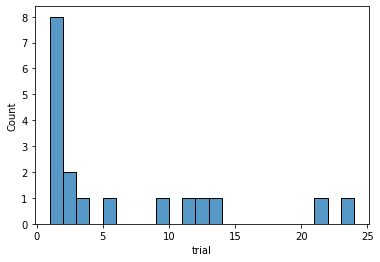

In [8]:
sns.histplot(errorsdf.trial,binwidth=1)

We can see 3 clusters of subjects here. The one on the far right seems purposefully to be messing around, the ones in the middle seem like maybe not paying attention, and the ones to the left seem fine. So let's set a boundary at greater than 5 to be removed from the data. (We can always revisit this as necessary!)

The following cell refines the dataframe of errors to just those with more than 5 errors, and generates a list of their IDs.

In [9]:
errorsdf=errorsdf[errorsdf.trial > 5]
toremove=errorsdf.SubjID.unique()
toremove

array(['3622caa97dab70', '3622cb4ae41c14', '3622cca948dbb0',
       '4622ca7e178487', '4622cb5bf78627', '4622cdfaa239a5'], dtype=object)

This cell removes those subjects. We can tell that they were removed by looking at the list of all subjects and checking it against the list above!

In [10]:
responsedf=responsedf[~responsedf.SubjID.isin(toremove)]
responsedf.SubjID.unique()

array(['26225154fb4590', 'test622642faa2bf5', 'test6227de33a0fb4',
       '16227ef7aaf0b5', '26227f09b50222', '26228e1fb2d623',
       '26228e20d3b275', '16228e21526e91', '16228e258094e6',
       '26228e26e41e3d', '16228e2ce08082', '1622a516d5edf1',
       '1622ac851c9a2b', '1622baa6c055f3', '3622ca6065dbe6',
       '4622ca7584dfc6', '4622ca77d3bb11', '3622cab55dbace',
       '3622caba79f77e', '4622cac790a39e', '4622cb0fae20a1',
       '3622ccbdccc9fe', '4622cd24039f56', '2622d94baad18f'], dtype=object)

### Fast and slow responses

Now, let's also remove any "fast" and "slow" responses -- this won't remove any subjects from the data, just the individual responses that were too fast or too slow, by keeping only responses that are "incorrect" and "ok".

In [11]:
responsedf = responsedf[responsedf.status.isin(['incorrect_response','OK'])]
responsedf.status.unique()

array(['OK', 'incorrect_response'], dtype=object)

**Question for discussion**: Are there any other reasons you can think of to exclude a participant's data?

## Part 1: voicing response x VOT

Now that our dataframe is cleaned up, let's look at the our findings and see whether we replicated the original paper's results!
First, let's check the main replication effect. As we can see in the figure below (copied from the original), we want a new dataframe with the following columns:
- word (this is our version of 'bias')
- vot
- voiced (this is out version of 'percent voiced response')

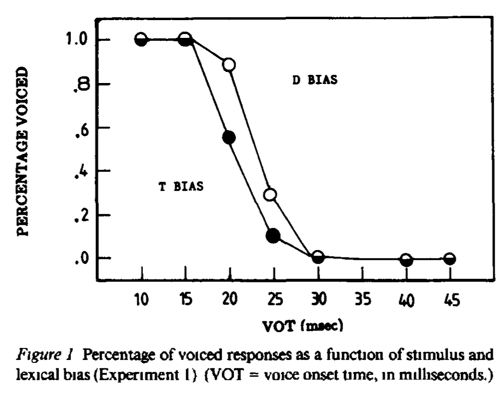

We can accomplish this by using the `groupby` function in pandas, which summarizes the numerical values of a dataframe according to a few key factors. Here, the key factors are the *independent variables* 'word' and 'vot'. The average values of the *dependent variable* 'voiced' will be generated for each combination of 'word' and 'vot'.

In [12]:
summarydf=responsedf.groupby(['word','vot']).mean().reset_index()
summarydf

,word,vot,trial,block,filedur,loadtime,rt,voiced
0,dice,0,22.776042,2.302083,630.0,32.135417,724.703125,0.989583
1,dice,20,23.453125,2.302083,630.0,30.052083,780.843750,0.869792
2,dice,40,24.894180,2.312169,630.0,31.931217,859.883598,0.301587
3,dice,60,25.455497,2.298429,630.0,31.544503,793.115183,0.026178
4,dice,80,25.041667,2.302083,630.0,30.859375,809.223958,0.026042
5,type,0,22.310881,2.362694,569.0,31.476684,873.559585,0.958549
6,type,20,25.162304,2.340314,569.0,25.026178,926.104712,0.748691
7,type,40,26.179487,2.348718,570.0,24.512821,997.897436,0.179487
8,type,60,22.903743,2.363636,568.0,23.235294,912.508021,0.021390
9,type,80,25.401015,2.345178,569.0,33.071066,874.614213,0.025381


Now, we can use [seaborn's `lineplot` function](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to generate a plot that looks like the one in the original paper! We'll put 'vot' on the x-axis, 'voiced' on the y-axis, and we'll separate the lines by the real 'word' within the series.

<AxesSubplot:xlabel='vot', ylabel='voiced'>

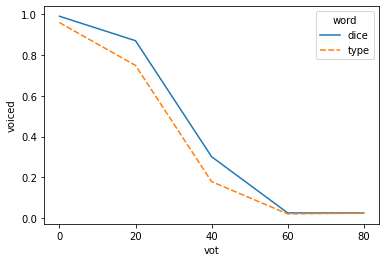

In [13]:
sns.lineplot(x='vot', y='voiced', hue='word', style='word', data=summarydf)

**Question for discussion**: What do you see? Did we find the same effect as the original paper?

## Part 2: reaction time

In addition to replicating Ganong's (1980) classic study, one of Connine and Clifton's (1987) goals was to investigate the plausibility of the heirarchical model vs. interactive model of contextual information in speech processing by way of reaction time predictions. In particular, they expected heirarchical models to "predict an advantage for word responses" compared to non-word responses. In other words, if RT is faster in real word responses than in nonword responses in ambiguous tokens, that favors the heirarchical model over the integrative model.

The first thing we should do is check that there is variation in reaction time in the first place! (There is.) This is a good place to use a histogram or density function.

<AxesSubplot:xlabel='rt', ylabel='Count'>

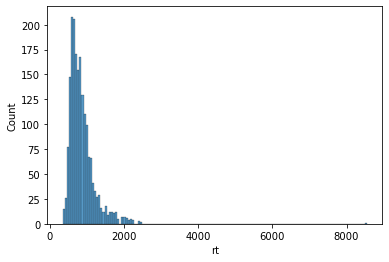

In [14]:
sns.histplot(responsedf.rt)

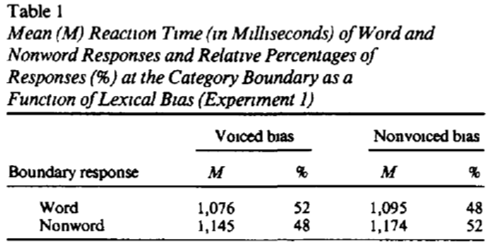

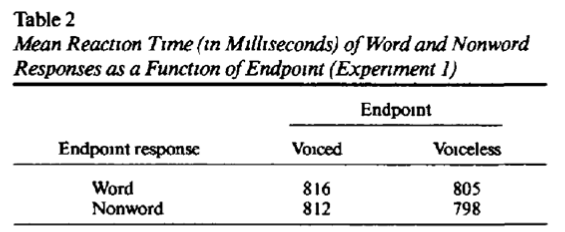

So a replication of these results would show slower reaction times in nonword responses around the boundary (around 30ms for "type" series and 40ms for "dice" series), but no difference in reaction time between nonword and word responses at the endpoints. Let's summarize our reaction time data by the series and VOT and response. *Note: I chose to use median rather than mean/average in this summary as it is more robust to the effects of extreme outliers.*

In [15]:
responsedf.groupby(['word', 'vot', 'response']).median().reset_index()

,word,vot,response,trial,block,filedur,loadtime,rt,voiced
0,dice,0,dice,21.0,2.0,630.0,5.0,655.0,1.0
1,dice,0,tice,23.5,1.5,630.0,2.5,478.5,0.0
2,dice,20,dice,23.0,2.0,630.0,5.0,749.0,1.0
3,dice,20,tice,23.0,2.0,630.0,5.0,784.0,0.0
4,dice,40,dice,26.0,2.0,630.0,5.0,1097.0,1.0
5,dice,40,tice,25.0,3.0,630.0,5.0,691.5,0.0
6,dice,60,dice,10.0,2.0,630.0,10.0,1165.0,1.0
7,dice,60,tice,25.5,2.0,630.0,5.0,720.5,0.0
8,dice,80,dice,1.0,1.0,630.0,20.0,1387.0,1.0
9,dice,80,tice,26.0,2.0,630.0,5.0,732.0,0.0


**Questions for discussion**: 
- Did we replicate the reaction time effects?
- Do we see a problem with the second part of the question, about nonword reaction times at the edges?

Mostly because we haven't seen one yet... here's a boxplot! It also happens to show a curious trend....

(0.0, 3000.0)

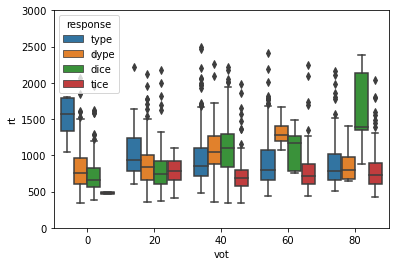

In [16]:
sns.boxplot(x='vot', y='rt', hue='response', data=responsedf, order=['0','20','40','60','80'])
plt.ylim([0,3000])

# Part 3

One thing Fox (1984) hypothesized is that the faster the response is, the less likely the participant is including contextual information in their decision-making process. This predicts that, if we divided our responses into fast/medium/slow categories, the fast category should show the *smallest* Ganong effect.

First, let's divvy up the responses. I landed on 650 and 900ms as the boundaries by trying to split the data equally between the three categories. This may not be the best way but it was fast!

In [17]:
responsedf['speed']=responsedf.rt.apply(lambda x: 'fast' if x<650 else ('slow' if x>900 else 'medium'))
responsedf.groupby(['speed']).count()

,SubjID,trial,block,file1,filedur,loadtime,status,response,option,rt,word,vot,voiced
speed,,,,,,,,,,,,,
fast,572,572,572,572,572,572,572,572,572,572,572,572,572
medium,721,721,721,721,721,721,721,721,721,721,721,721,721
slow,626,626,626,626,626,626,626,626,626,626,626,626,626


<AxesSubplot:xlabel='vot', ylabel='voiced'>

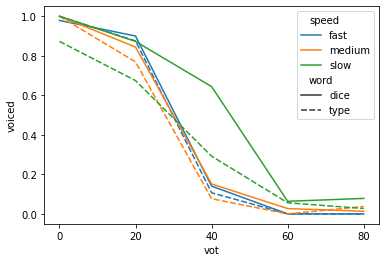

In [18]:
summarydf=responsedf.groupby(['word','vot','speed']).mean().reset_index()
sns.lineplot(x='vot', y='voiced', hue='speed', style='word', data=summarydf)

**Question for discussion**: 
- Do our results support this prediction?
- Do you have any ideas for other ways we could explore this data?